# Film Junky Union

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Aquí se describen los campos seleccionados:

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Inicialización

In [68]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import transformers

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [41]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [42]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [43]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

El dataframe cuenta con 47331 filas y 16 columnas. No se observan datos ausentes. Las columnas relevantes para este proyecto son del tipo correcto de datos.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

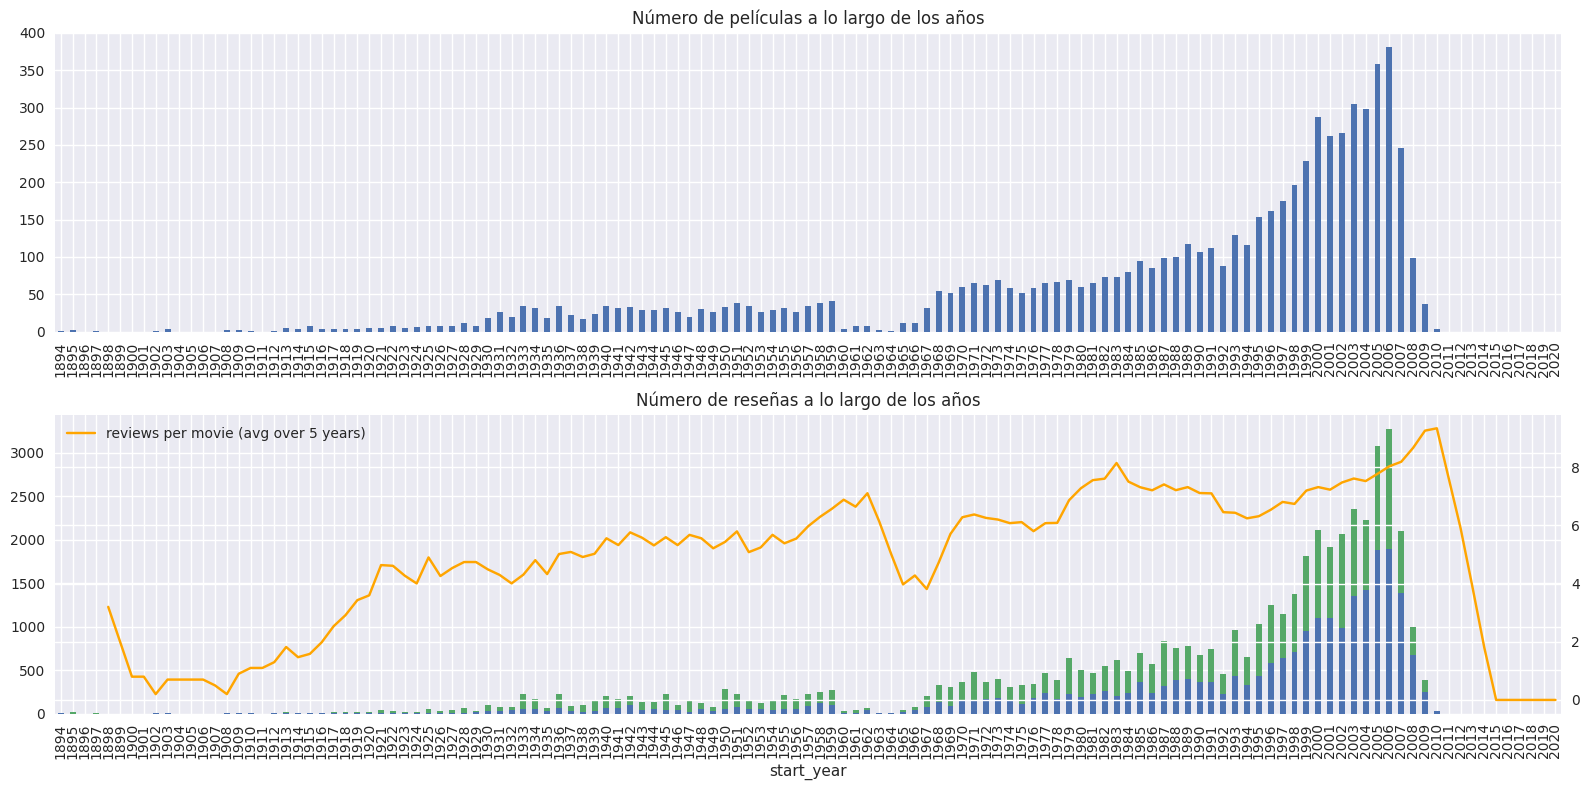

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Es evidente que la producción de películas presenta una tendencia creciente a lo largo del tiempo. De igual manera, se observa en promedio, que las reseñas tienen un comportamiento creciente, esto puede deberse al acceso a la tecnología y la última caída por que no se tienen datos actuales.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

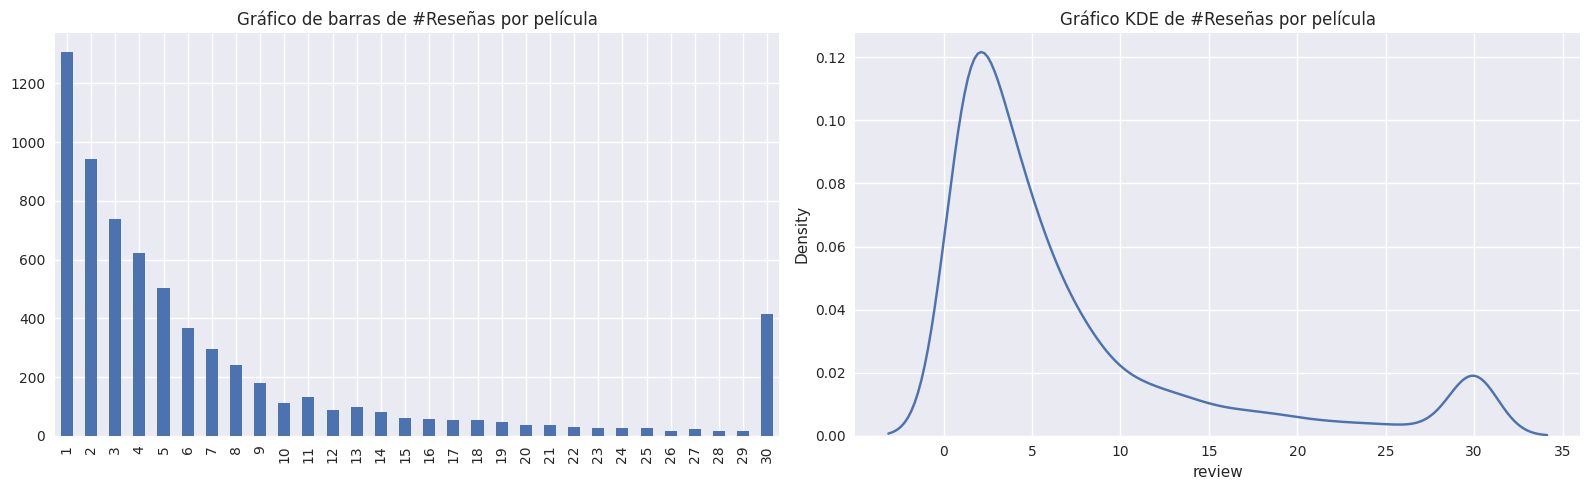

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Se pudo observar que la mayoría de películas tiene pocas reseñas y unas pocas concentran la mayor parte de reseñas. Esto puede deberse a pocas películas con gran trascendencia y popularidad, y más películas con baja visibilidad. Esto se ratifica en el gráfico KDE.

In [46]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Se evidencia que no existe desbalanceo de clases ya que tanto la categoría positiva como la negativa comprenden aproximadamente un 50% de los datos. Por este motivo no es necesario aplicar técnicas de balanceo de clases. 

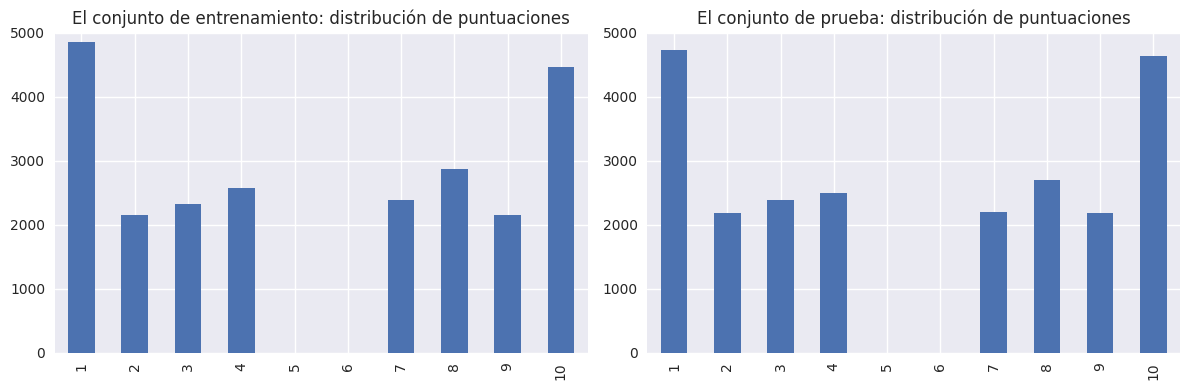

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Con las gráficas previas, se puede evidenciar que la división del conjunto de entrenamiento y prueba está bien distribuida ya que las graficas tienen formas muy parecidas. Por otra parte, se observa que el rating está polarizado en calificaciones muy malas y excelentes en su mayoría.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


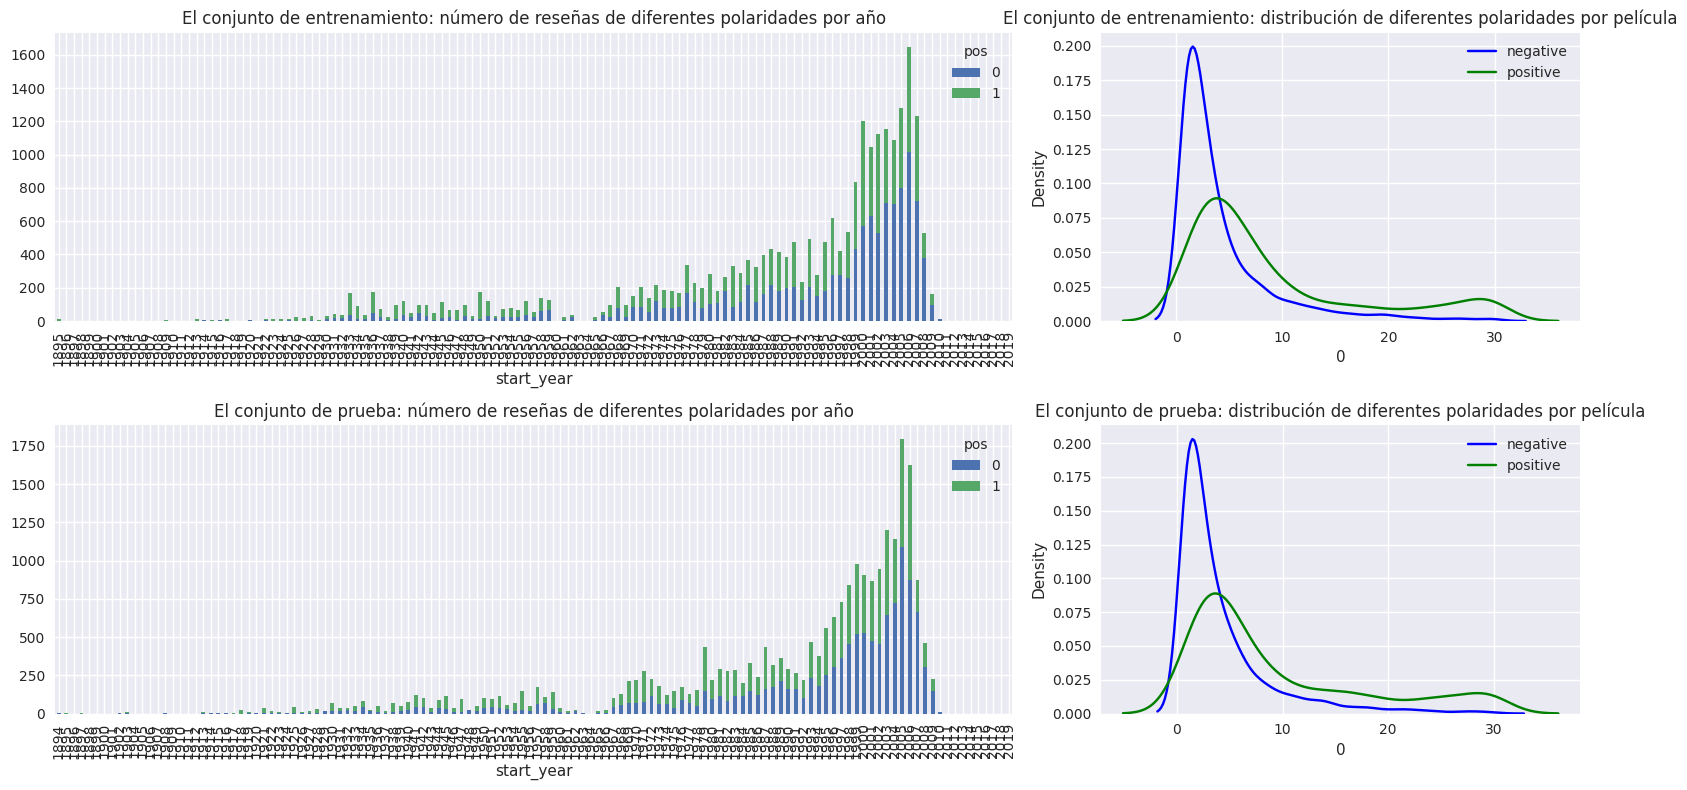

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se observa que existe una tendencia creciente de reseñas a lo largo del tiempo, con mayor proporción de reseñas positivas que negativas, tanto en el conjunto de entrenamiento como en el de prueba. Analizando las distribuciones de las reseñas se evidencia que en ambos conjuntos de entrenamiento y prueba, se evidencia que las reseñas negativas son más frecuentes en películas con pocas reseñas y las positivas tienen una distribución ligeramente mayor en películas con más cantidad de reseñas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [49]:

import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return


## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [50]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub(r"[^a-zA-Z\s]", '', x.lower()))
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r"\s+", " ", x.strip()))


print(df_reviews['review'][2])
print('')
print(df_reviews['review_norm'][2])

There is no real story the film seems more like a fly on the wall drama-documentary than a proper film so this piece may in itself be a spoiler. Teen drama about 3 young Singaporean kids (very similar to UK chavs) who play truant from school, run with gangs, get into fights, insult people on the street, get tattoos, hang about doing nothing, etc. etc, They generally imagine themselves to be hard and every so often shout challenging rap chants into the camera. Filmed in MTV style, fast cuts, crazy camera angles, tight close ups and animation interludes. The dialogue might have been crisper in the original languages of Mandarin and Hokkien than in the subtitles and I have no doubt that some of the contemporary Singapore references will slip over Western heads as well as the cultural and political context unless of course you are familiar with Singapore. This kind of teen film may be a first for Singapore but it has been done before and done better in other Western countries, La Haine (19

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [51]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [52]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


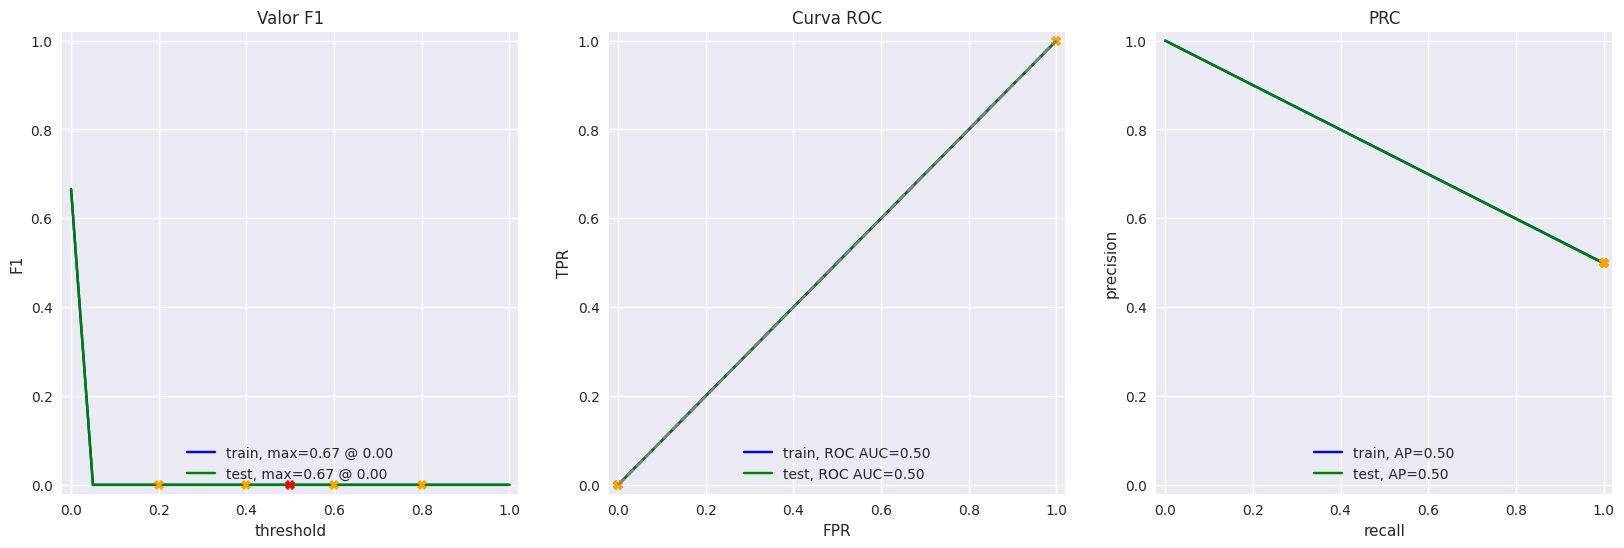

In [53]:
train_features_0 = np.zeros((len(df_reviews_train), 1))
test_features_0 = np.zeros((len(df_reviews_test), 1))

model_dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dummy.fit(train_features_0, train_target)

#Evaluar el modelo
evaluate_model(model_dummy, train_features_0, train_target, test_features_0, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [54]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [55]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(stop_words = stop_words)
train_features_1 = vectorizer.fit_transform(train_features)
test_features_1 = vectorizer.transform(test_features)

model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1, train_target)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


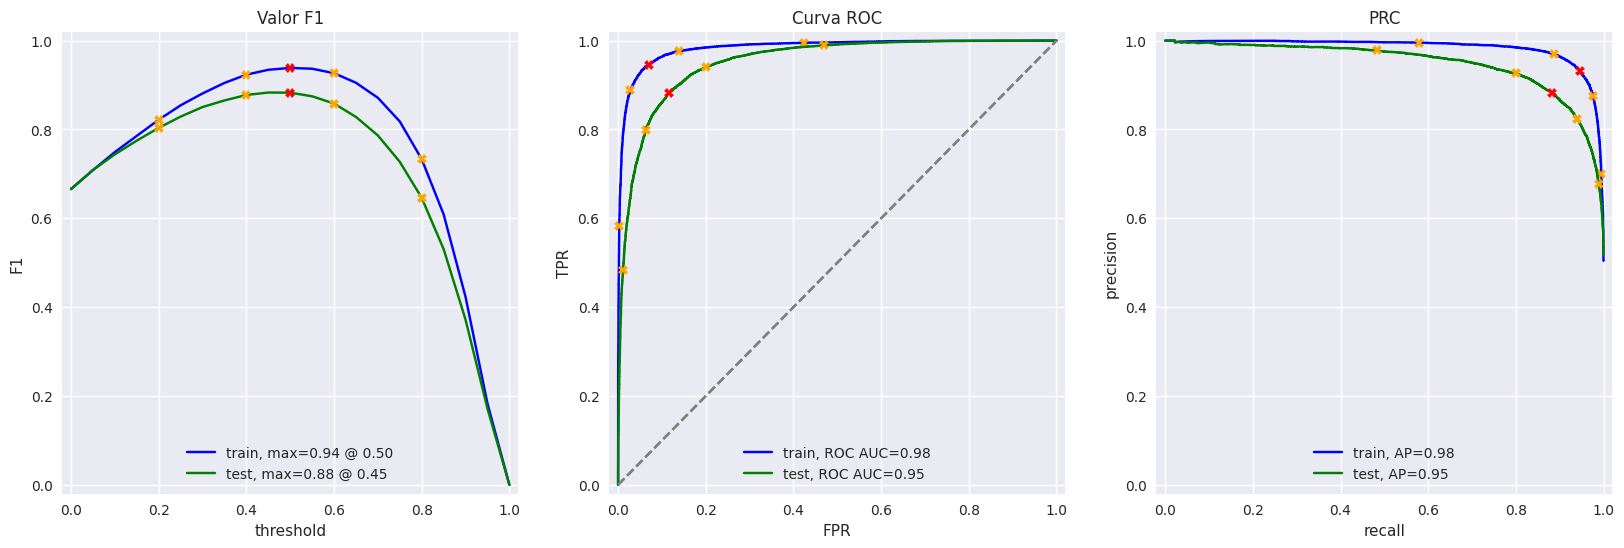

In [56]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 2 - spaCy, TF-IDF y LR

In [57]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [58]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    return ' '.join(tokens)

In [59]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

vectorizer_spacy = TfidfVectorizer()

train_features_2 = vectorizer_spacy.fit_transform(train_features)
test_features_2 = vectorizer_spacy.transform(test_features)


  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [60]:
model_2 = LogisticRegression(random_state=12345)
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


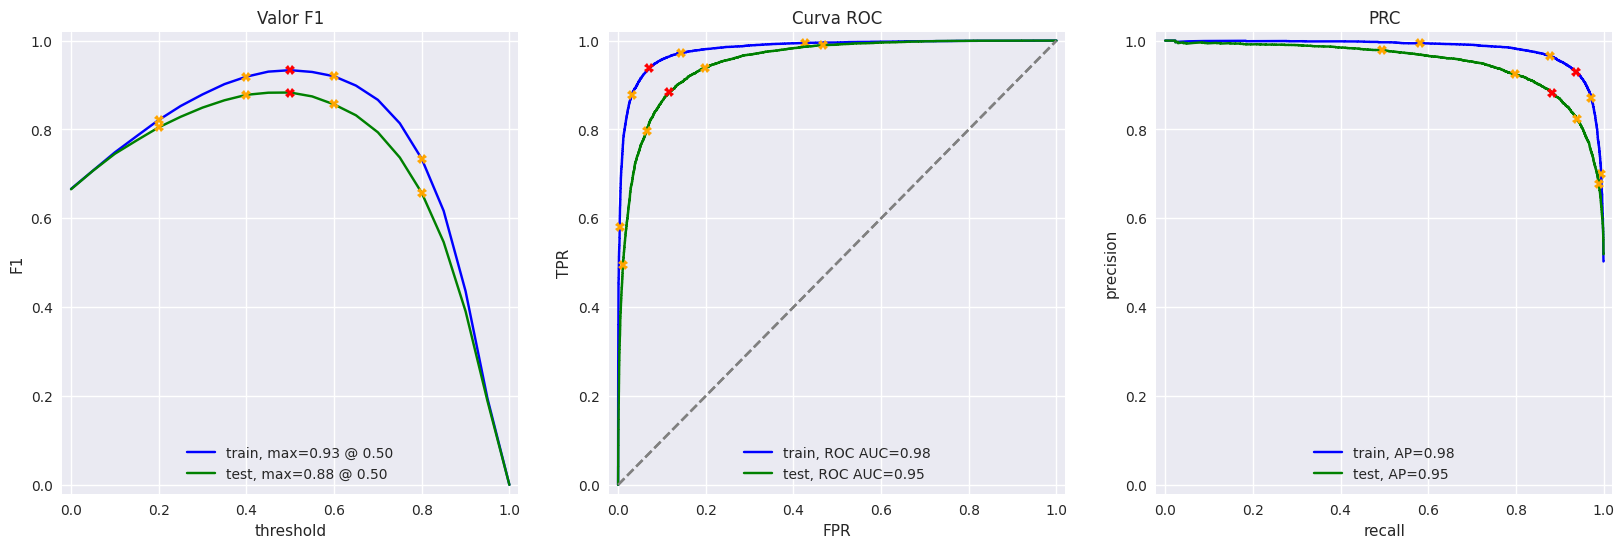

In [61]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [62]:
from lightgbm import LGBMClassifier

In [63]:
train_features_3 = vectorizer_spacy.fit_transform(train_features)
test_features_3 = vectorizer_spacy.transform(test_features)

In [64]:
model_3 = LGBMClassifier(random_state = 12345, class_weight="balanced", n_estimators=600,
    learning_rate=0.05)
model_3.fit(train_features_3, train_target)

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=600,
               random_state=12345)

          train  test
Accuracy   0.99  0.88
F1         0.99  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


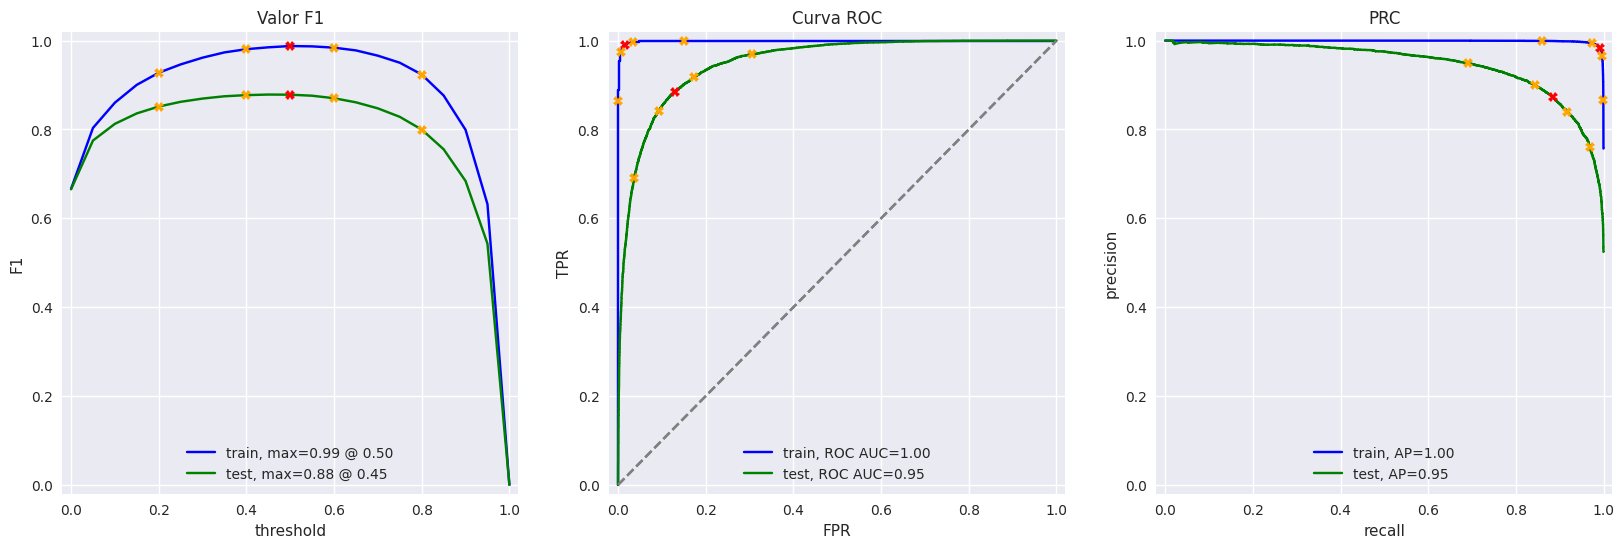

In [65]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Modelo 4 - spaCy, TF-IDF y XGBClassifier

In [66]:
train_features_4 = vectorizer_spacy.fit_transform(train_features)
test_features_4 = vectorizer_spacy.transform(test_features)

In [71]:
model_4 = XGBClassifier(random_state = 12345)
model_4.fit(train_features_4, train_target)

[03:46:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=12345,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


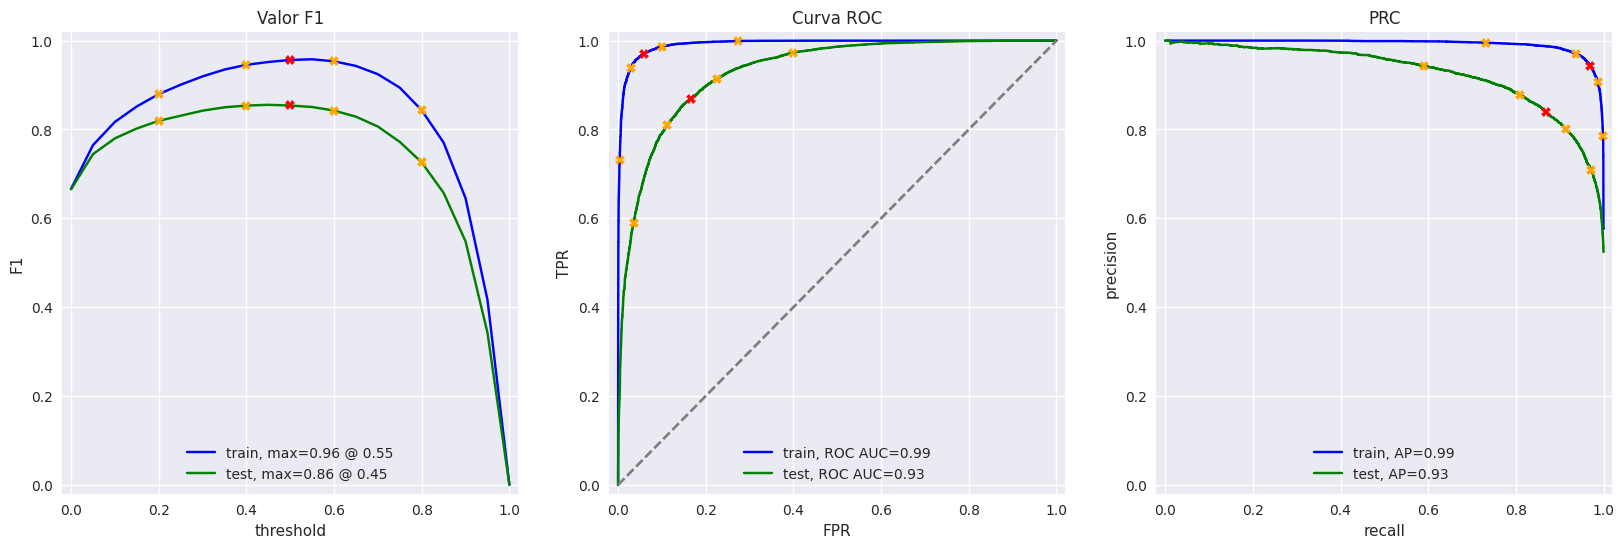

In [72]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Modelo 5 - spaCy, TF-IDF y RandomForest

In [89]:
from sklearn.ensemble import RandomForestClassifier

train_features_5 = vectorizer_spacy.fit_transform(train_features)
test_features_5 = vectorizer_spacy.transform(test_features)

model_5 = RandomForestClassifier(random_state=12345, n_estimators=10)
model_5.fit(train_features_5, train_target)

RandomForestClassifier(n_estimators=10, random_state=12345)

          train  test
Accuracy   0.99  0.73
F1         0.99  0.70
APS        1.00  0.77
ROC AUC    1.00  0.80


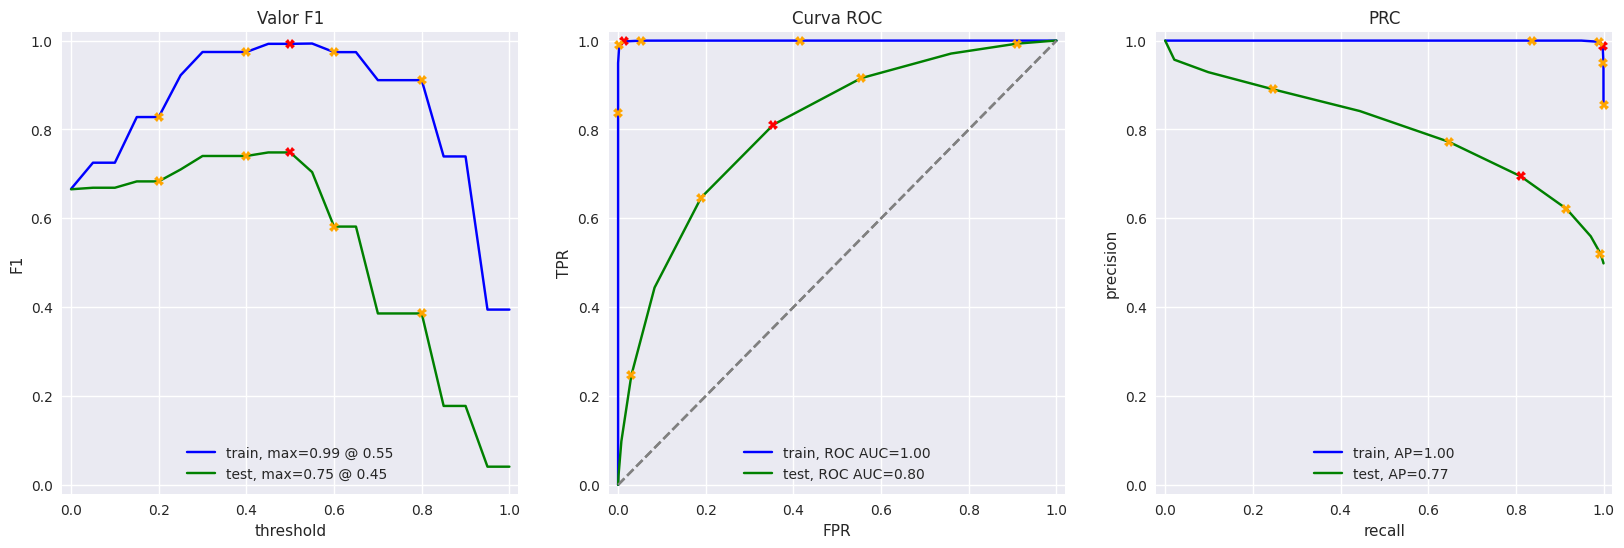

In [90]:
evaluate_model(model_5, train_features_5, train_target, test_features_5, test_target)

###  Modelo 9 - BERT

In [73]:
import torch
import transformers

In [74]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [75]:

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención

    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    encoded = tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_attention_mask=True,
        return_tensors= None
    )
    ids_list = encoded['input_ids']
    attention_mask_list = encoded['attention_mask']
        

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # obtener insertados en lotes

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)



In [76]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')


In [77]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

No se puede correr el código BERT, por lo tanto no se podrá ejecutar el modelo 9.

In [78]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [79]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub(r"[^a-zA-Z\s]", '', x.lower()))
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: re.sub(r"\s+", " ", x.strip()))


my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 1

In [80]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 2

In [82]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.24:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25:  i didnt expect the reboot to be so good writers really cared about the source material
0.44:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [83]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = vectorizer_spacy
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.23:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.52:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.62:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.72:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [85]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer_spacy
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  i did not simply like it not my kind of movie
0.34:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.63:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.56:  i didnt expect the reboot to be so good writers really cared about the source material
0.63:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.32:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.63:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [ ]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
#    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

- El modelo dummy es un baseline que no aporta nada, no alcanza el valor mínimo requerido de F1.
- Todos los modelos superan el valor mínimo establecido de 0.85 para F1 a excepción del modelo dummy y el RandomForestClassifier.
- Los modelos NLTK + TF-IDF + Logistic Regression y spaCy + TF-IDF + Logistic Regression tienen un rendimiento muy bueno, sin embargo, se observa que no existe gran diferencia al emplear TF-IDF o Spacy con Regresion Logistica para este conjunto de datos.
- Los modelos LightGBM y RandomForest muestran gran sobreajuste por tener un rendimiento casi perfecto en train pero más deficiente en test. De igual manera pero en menor medida, el modelo XGBoost muestra sobreajuste.
- Los modelos fueron probados en las nuevas reseñas y hacen evidente el mejor rendimiento en los modelos con Regresion Logistica. Los modelos LGBM y XGB generan probabilidades más neutrales perdiendo el enfoque de las reseñas, al contrario de los otros modelos con LR que devuelven probabilidades más coherentes.
- El modelo más adecuado para este conjunto de datos corresponde a NLTK + TF-IDF + Logistic Regression.
- No se pudo generar el modelo BERT porque el kernel se reiniciaba, sin embargo se completó el código para obtener los embeddings.